### Experiment Overview

#### Objective
The primary goal of this experiment is to observe and analyze the behavior of magnetization in response to different types of frequency sweeps - linear and tangential - in a magnetic resonance setup.

#### Key Components

1. **Magnetic Fields**:
   - **Static Field (B0):** A constant magnetic field that aligns the magnetization along the Z-axis.
   - **Oscillating Fields (B1):** These are varying magnetic fields used to manipulate the magnetization. Different oscillating fields are used for linear and tangential sweeps.

2. **Frequency Sweeps**:
   - **Linear Sweep:** The frequency of the oscillating field changes linearly over time. This traditional method is straightforward and provides a baseline for comparison.
   - **Tangential Sweep:** An alternative approach where the frequency of the oscillating field changes following a tangential function. This method is proposed to be more efficient under certain conditions, such as the presence of radiofrequency (rf) field inhomogeneity and frequency offset.

#### Experiment Process

- **Initial Setup:** The system starts with the magnetization vector aligned along the Z-axis due to the static magnetic field (B0).
- **Application of B1 Fields:** Two different B1 fields are applied in two separate experiments – one for the linear sweep and the other for the tangential sweep. These fields are responsible for the manipulation of the magnetization vector.
- **Frequency Sweeps:** 
  - In the linear sweep, the frequency of B1 linearly varies over the sweep time.
  - In the tangential sweep, the frequency of B1 follows a tan function, theoretically providing better control over magnetization under specific conditions.

#### Observations and Analysis

- **Magnetization Vector (m):** The behavior of the magnetization vector in response to these sweeps is observed and analyzed.
- **Effective Magnetic Field (Beff):** The angle between the magnetization vector and the effective magnetic field is calculated over time for both types of sweeps.
- **Comparative Analysis:** The results from both sweeps are compared to understand the efficiency and effectiveness of the tangential sweep relative to the traditional linear sweep.

#### Significance

This experiment provides insights into the dynamics of magnetic resonance and the potential advantages of using a tangential frequency sweep in specific scenarios, especially in terms of power efficiency and control over the magnetization vector.

As a first step, let's calculate the angle with the Z axis of the effective field and of the magnetization as a function of time.

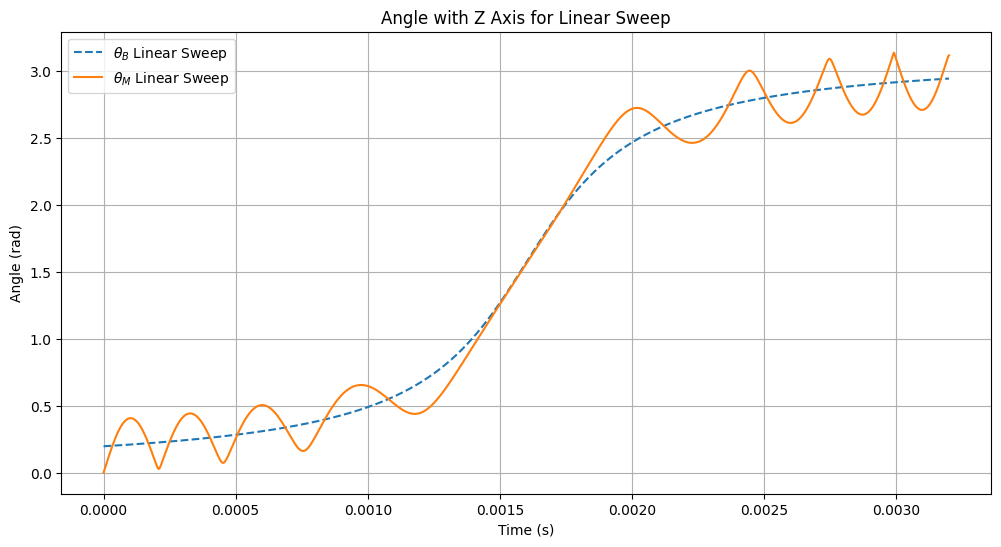

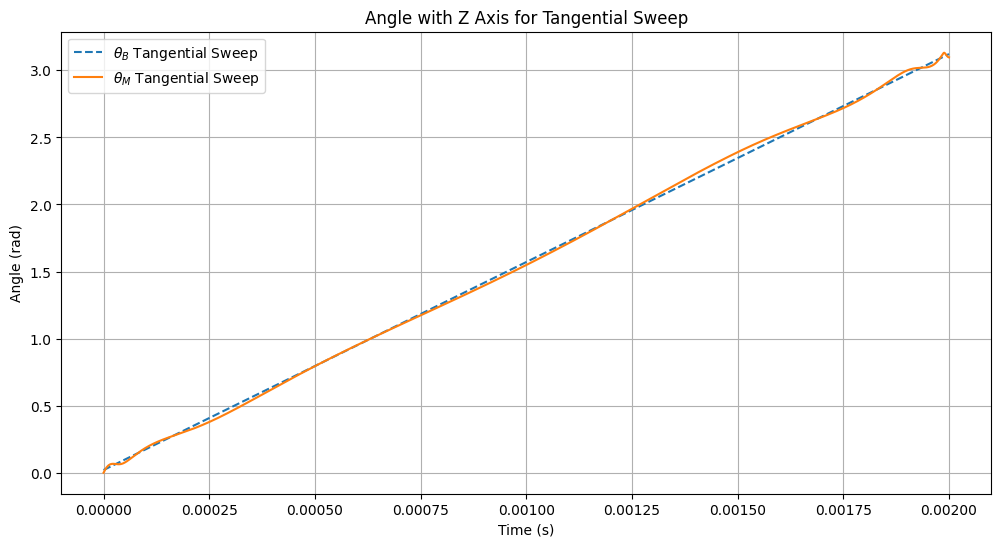

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
gamma = 2.675e8  # gyromagnetic ratio for protons (rad/s/T)
B0 = 9.5  # static field strength in T
B1_lin = 0.235e-4  # B1_lin in Tesla (0.235 G converted to T)
B1_tan = 0.235e-4
omega_0 = -gamma * B0  # resonance angular frequency for static field B0
T0_lin = 3.2e-3  # 3.2 ms sweep time for the linear sweep
T0_tan = 2e-3
Delta_omega_lin = 2 * np.pi * 5e3  # ±5 kHz sweep range in rad/s for the linear sweep
Delta_omega_tan = 2 * np.pi * 50e3  # ±5 kHz sweep range in rad/s for the linear sweep

# Initial magnetization vector (aligned with Z-axis)
m0 = np.array([0, 0, 1])

# Function to define the linear sweep
def linear_sweep(t, T0_lin, Delta_omega_lin):
    return omega_0 - (2 * Delta_omega_lin * t / T0_lin) + Delta_omega_lin

# and tangential sweep
def tangential_sweep(t, T0_tan, Delta_omega_tan):
    omega_1 = gamma * B1_tan
    # Adjust the time range from [0, T0_lin] to [-T0_lin/2, T0_lin/2]
    # Calculate alpha using the previously given equation
    alpha = (2 / (omega_1 * T0_tan)) * np.arctan(Delta_omega_tan / omega_1)
    # Calculate the instantaneous frequency using the tangential function
    # Adjust the time range from [0, T0_tan] to [-T0_tan/2, T0_tan/2]
    adjusted_time = (t - T0_tan / 2)

    # Calculate the instantaneous frequency using the tangential function
    omega_t = omega_0 - omega_1 * np.tan(alpha * omega_1 * adjusted_time)
    return omega_t

# Function to calculate the differential for the rotating frame equation
def rotating_frame_eq(t, m, B1, sweep_function):
    omega_t = sweep_function(t)
    Beff_y = B1
    Beff_z = (omega_t - omega_0) / gamma
    Beff = np.array([0, Beff_y, Beff_z])
    dm_dt = gamma * np.cross(m, Beff)
    return dm_dt

# Function to calculate the angle with the Z-axis
def angle_with_z_axis(vector):
    z_axis = np.array([0, 0, 1])
    dot_product = np.dot(z_axis, vector)
    vector_magnitude = np.linalg.norm(vector)
    return np.arccos(dot_product / vector_magnitude)

# Solve the differential equation using solve_ivp
sol_linear = solve_ivp(
    rotating_frame_eq,
    (0, T0_lin),
    m0,
    args=(B1_lin, lambda t: linear_sweep(t, T0_lin, Delta_omega_lin)),
    method='RK45',
    t_eval=np.linspace(0, T0_lin, 4096)
)

# Solve the differential equation using solve_ivp
sol_tangential = solve_ivp(
    rotating_frame_eq,
    (0, T0_tan),
    m0,
    args=(B1_tan, lambda t: tangential_sweep(t, T0_tan, Delta_omega_tan)),
    method='RK45',
    t_eval=np.linspace(0, T0_tan, 4096)
)

# Linear sweep plotting

# Calculate the angles between Z axis and Beff for the linear sweep
theta_B_linear = np.array([angle_with_z_axis(np.array([0, B1_lin, (linear_sweep(t, T0_lin, Delta_omega_lin) - omega_0) / gamma]))
                          for t in sol_linear.t])

# Calculate the angles between Z axis and m for the linear sweep
theta_M_linear = np.array([angle_with_z_axis(m) for m in sol_linear.y.T])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sol_linear.t, theta_B_linear, label=r'$\theta_B$ Linear Sweep', linestyle='--')
plt.plot(sol_linear.t, theta_M_linear, label=r'$\theta_M$ Linear Sweep')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle with Z Axis for Linear Sweep')
plt.legend()
plt.grid(True)
plt.show()

# Tangential sweep plotting

# Calculate the angles between Z axis and Beff for the linear sweep
theta_B_tangential = np.array([angle_with_z_axis(np.array([0, B1_tan, (tangential_sweep(t, T0_tan, Delta_omega_tan) - omega_0) / gamma]))
                          for t in sol_tangential.t])

# Calculate the angles between Z axis and m for the linear sweep
theta_M_tangential = np.array([angle_with_z_axis(m) for m in sol_tangential.y.T])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sol_tangential.t,  theta_B_tangential, label=r'$\theta_B$ Tangential Sweep', linestyle='--')
plt.plot(sol_tangential.t, theta_M_tangential, label=r'$\theta_M$ Tangential Sweep')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle with Z Axis for Tangential Sweep')
plt.legend()
plt.grid(True)
plt.show()

Now, let's plot the angle between the effective field and the magnetization

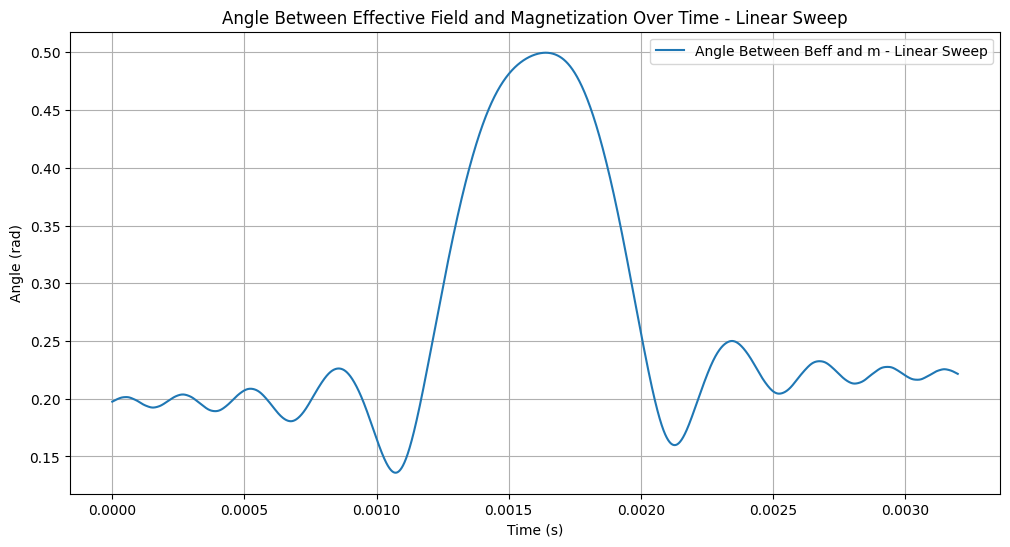

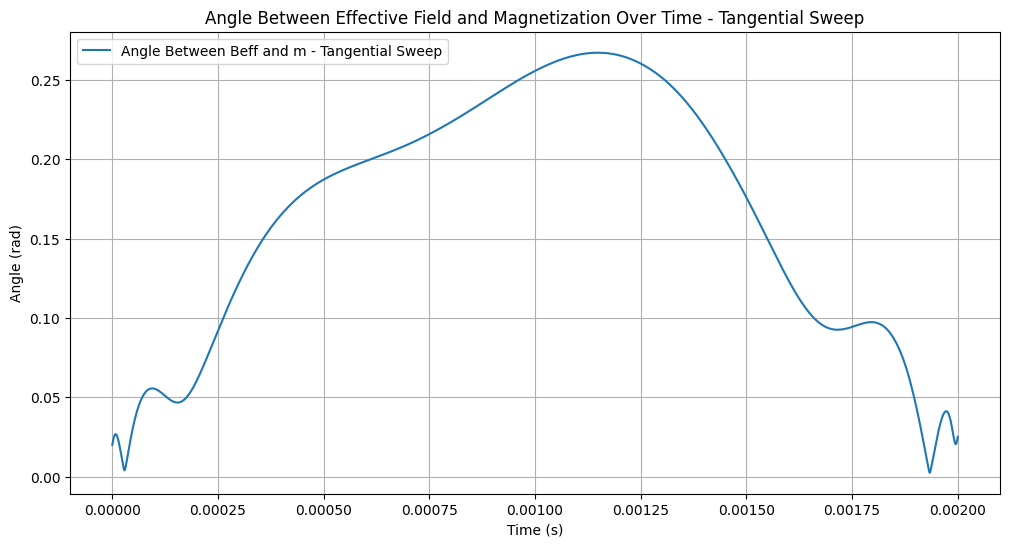

In [2]:
# Function to calculate the angle between two vectors
def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    return np.arccos(dot_product / (magnitude_v1 * magnitude_v2))

# Linear Sweep: Calculating Beff and m at each time point
Beff_linear = np.array([np.array([0, B1_lin, (linear_sweep(t, T0_lin, Delta_omega_lin) - omega_0) / gamma]) for t in sol_linear.t])
m_linear = sol_linear.y.T

# Tangential Sweep: Calculating Beff and m at each time point
Beff_tangential = np.array([np.array([0, B1_tan, (tangential_sweep(t, T0_tan, Delta_omega_tan) - omega_0) / gamma]) for t in sol_tangential.t])
m_tangential = sol_tangential.y.T

# Calculating angles for Linear and Tangential sweeps
angle_linear = np.array([angle_between_vectors(Beff_linear[i], m_linear[i]) for i in range(len(sol_linear.t))])
angle_tangential = np.array([angle_between_vectors(Beff_tangential[i], m_tangential[i]) for i in range(len(sol_tangential.t))])

# Plotting the results separately for Linear and Tangential sweeps

# Plot for Linear Sweep
plt.figure(figsize=(12, 6))
plt.plot(sol_linear.t, angle_linear, label='Angle Between Beff and m - Linear Sweep')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle Between Effective Field and Magnetization Over Time - Linear Sweep')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Tangential Sweep
plt.figure(figsize=(12, 6))
plt.plot(sol_tangential.t, angle_tangential, label='Angle Between Beff and m - Tangential Sweep')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle Between Effective Field and Magnetization Over Time - Tangential Sweep')
plt.legend()
plt.grid(True)
plt.show()